In [1]:
import sys
sys.path.append("..")

In [2]:
from src.assay_calibration.fit_utils.two_sample.fit import single_fit
from src.assay_calibration.fit_utils.two_sample import (density_utils,constraints, optimize)
import scipy.stats as sps
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import trange

In [3]:
def generate_scoreset(params, weights, sample_sizes):
    samples = []
    sample_assignments = []
    assert weights.shape[1] == len(params)
    assert len(sample_sizes) == weights.shape[0]
    for sampleNum,(sample_weights, sample_size) in enumerate(zip(weights, sample_sizes)):
        comp_sizes = np.round(sample_weights * sample_size).astype(int)
        for compParams, compSize in zip(params, comp_sizes):
            if compSize <= 0:
                continue
            samples.append(sps.skewnorm.rvs(compParams[0], loc=compParams[1], scale=compParams[2], size=compSize))
            sa = np.zeros((compSize, len(params)), dtype=bool)
            sa[:,sampleNum] = True
            sample_assignments.append(sa)
    return np.concatenate(samples), np.concatenate(sample_assignments)


trueParams = [
    (-2, -3, 2),  # Component 1: a, loc, scale
    (0, 0, 1),   # Component 2: a, loc, scale
    (2, 3, 1)   # Component 3: a, loc, scale
]
trueWeights = np.array([[.45, .25, .3], # Pathogenic 
                        [.01, .01, 0.98], # Benign
                        [0.02, 0.1, .88]], dtype=float) # gnomAD
assert np.allclose(trueWeights.sum(1), 1)

sample_sizes = np.array([500,500, 1000])

scores, sample_assignments = generate_scoreset(trueParams, trueWeights, sample_sizes)
score_range = np.linspace(min(scores),max(scores), 1000)

In [4]:
# from tsc2.data_utils import load_data

In [5]:
# tsc2 = load_data("dataframe.xlsx")

In [6]:
# tsc2['cliPE']

In [7]:
scores.shape, sample_assignments.shape

((2000,), (2000, 3))

In [8]:
# constrained_result,message = optimize.project_to_monotone_lrPlus([*trueParams,[trueWeights[0],
#                                                                                trueWeights[1]]],
#                                                             score_range[0],score_range[-1],)

In [9]:
# constraints.positive_likelihood_ratio_montonicity_constraint_violated(constrained_result[:3],
#                                                                       constrained_result[3][0],
#                                                                       constrained_result[3][1],
#                                                                       score_range[[0,-1]])

$ LR+ = \frac{w^p_0 * f_0(x) + w^p_1 * f_1(x) + w^p_2* f_2(x)}{w^b_0 * f_0(x) + w^b_1 * f_1(x) + w^b_2* f_2(x)} $

In [10]:
def get_log_density_ratios(score_range, params):
    ratios = np.zeros((len(params) - 1, len(score_range)))
    for i in range(1, len(params)):
        ratios[i-1] = (sps.skewnorm.logpdf(score_range, params[i-1][0], loc=params[i-1][1], scale=params[i-1][2]) -
                       sps.skewnorm.logpdf(score_range, params[i][0], loc=params[i][1], scale=params[i][2]))
    return ratios

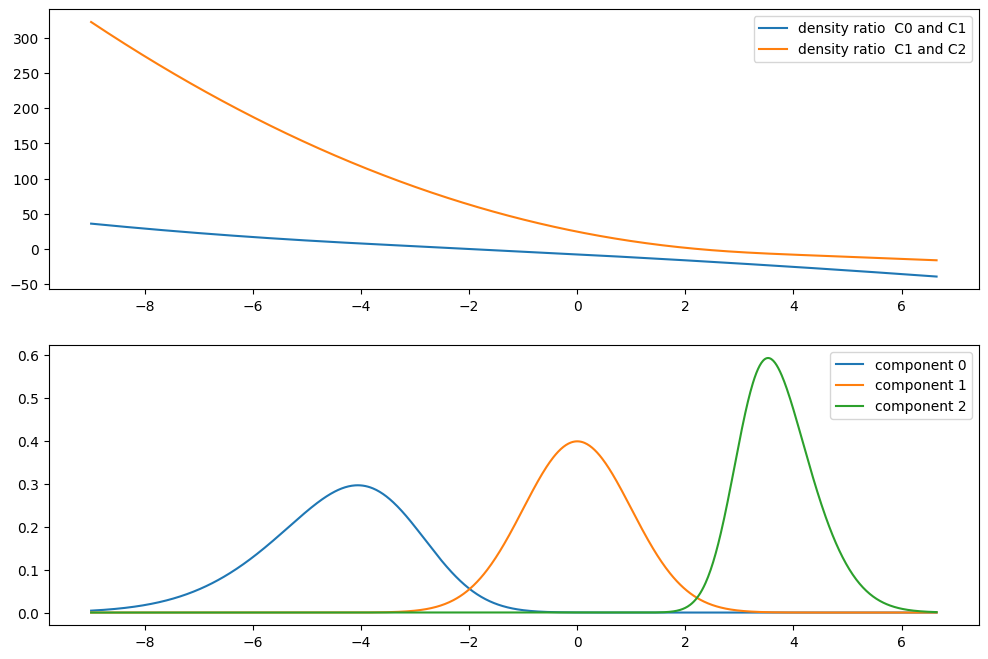

In [11]:
score_range = np.linspace(scores.min(), scores.max(), 1000)
fig,ax = plt.subplots(2,1, figsize=(12,8))
ratios = get_log_density_ratios(score_range, trueParams)
# ax[0].plot(score_range, ratios.T)
ax[0].plot(score_range, ratios[0],label="density ratio  C0 and C1")
ax[0].plot(score_range, ratios[1],label="density ratio  C1 and C2")
component_densities = np.array([
    sps.skewnorm.pdf(score_range, a, loc=loc, scale=scale) for a,loc,scale in trueParams
])
for i, pdf in enumerate(component_densities):
    ax[1].plot(score_range, pdf,label=f"component {i}")
[axi.legend() for axi in ax]

Text(0, 0.5, 'log LR+')

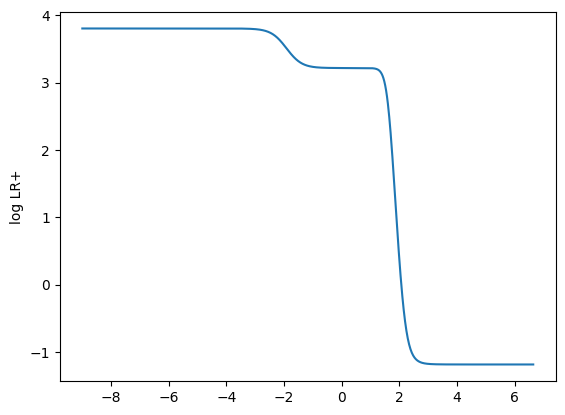

In [12]:
fig, ax = plt.subplots(1,1)
f_pathogenic = density_utils.mixture_pdf(score_range, trueParams, trueWeights[0])
f_benign = density_utils.mixture_pdf(score_range, trueParams, trueWeights[1])
lrPlus = np.log(f_pathogenic) - np.log(f_benign)
diffs = np.diff(lrPlus)
ax.plot(score_range, lrPlus)
ax.set_ylabel("log LR+")

In [13]:
scores.shape, sample_assignments.shape

((2000,), (2000, 3))

In [14]:
# fit_results = [single_fit(scores,sample_assignments,3, True,
#                           initial_weights=trueWeights,
#                           initial_params=trueParams) for _ in trange(10)]

fit_results = [single_fit(scores,sample_assignments,3,False, init_method="kmeans") for _ in trange(10)]

fit_results = sorted(fit_results, key=lambda res: res['likelihoods'][-1], reverse=True)
best_fit = fit_results[0]

  0%|          | 0/10 [00:00<?, ?it/s]

init_method: kmeans, params: [[-0.4877126630247471, -4.572565007369176, 1.3546980236156596], [2.0242902331280472, -0.04420952708339274, 0.9398511576495285], [1.116693801535461, 3.753419063693166, 0.6997432476137553]]


EM Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

init_method: kmeans, params: [[-0.48126645775935495, -4.572565007369176, 1.3546980236156596], [1.2315987128615637, -0.04420952708339274, 0.9398511576495285], (0.15593261050202667, 3.753419063693166, 0.6997432476137553)]


EM Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

init_method: kmeans, params: [[-0.47454943700681557, -4.572565007369176, 1.3546980236156596], [0.34251747068327243, -0.04420952708339274, 0.9398511576495285], (-0.12471618737464457, 3.753419063693166, 0.6997432476137553)]


EM Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

init_method: kmeans, params: [[-0.5037645311765995, -4.572565007369176, 1.3546980236156596], [-0.031090166105297783, -0.04420952708339274, 0.9398511576495285], (0.002520405819530669, 3.753419063693166, 0.6997432476137553)]


EM Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

init_method: kmeans, params: [[-0.48036601238303955, -4.572565007369176, 1.3546980236156596], [1.2264247779662956, -0.04420952708339274, 0.9398511576495285], [-0.03762706208427259, 3.753419063693166, 0.6997432476137553]]


EM Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

init_method: kmeans, params: [[-0.48335607700526734, -4.572565007369176, 1.3546980236156596], [0.3769162162968789, -0.04420952708339274, 0.9398511576495285], (0.1439603434140277, 3.753419063693166, 0.6997432476137553)]


EM Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

init_method: kmeans, params: [[-0.5001576012305534, -4.572565007369176, 1.3546980236156596], [-0.07521391963831107, -0.04420952708339274, 0.9398511576495285], (0.2347292584077731, 3.753419063693166, 0.6997432476137553)]


EM Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

init_method: kmeans, params: [[-0.488594835101185, -4.572565007369176, 1.3546980236156596], [0.3096793223535756, -0.04420952708339274, 0.9398511576495285], (-0.08647473348899765, 3.753419063693166, 0.6997432476137553)]


EM Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

init_method: kmeans, params: [[-0.48028517763025796, -4.572565007369176, 1.3546980236156596], [-0.007078461351575022, -0.04420952708339274, 0.9398511576495285], (0.15593045399479294, 3.753419063693166, 0.6997432476137553)]


EM Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

init_method: kmeans, params: [[-0.49373368021143893, -4.572565007369176, 1.3546980236156596], [-0.017496165628137945, -0.04420952708339274, 0.9398511576495285], (0.11887654681571197, 3.753419063693166, 0.6997432476137553)]


EM Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

In [15]:
score_range = np.linspace(scores.min(), scores.max(), 1000)
trueDensities = np.array([density_utils.joint_densities(score_range[...,None], trueParams, sample_weights).squeeze() for sample_weights in trueWeights])
estimatedDensities = np.array([density_utils.joint_densities(score_range[...,None],
                                                             best_fit['component_params'],
                                                             sample_weights).squeeze() for sample_weights in best_fit['weights']])

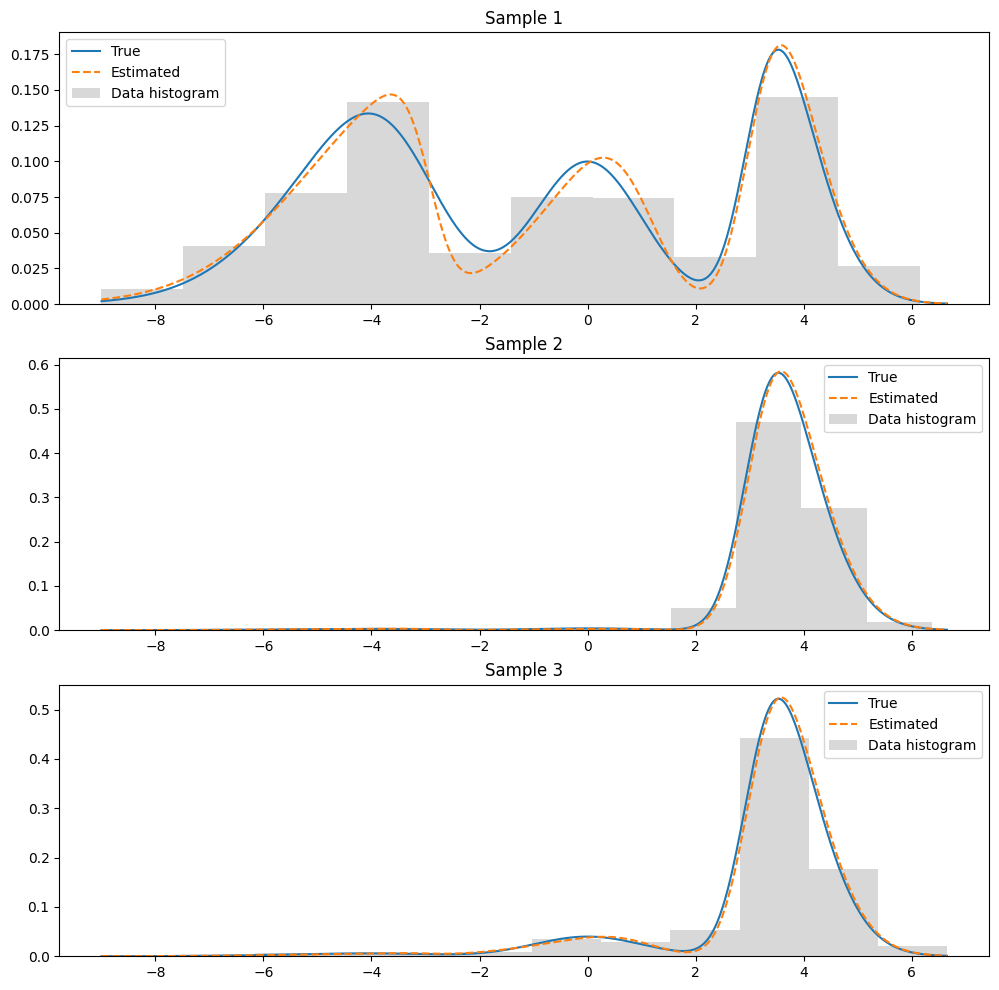

In [16]:
fig,ax = plt.subplots(3,1, figsize=(12,12))
for i in range(3):
    ax[i].plot(score_range, trueDensities[i].sum(0), label='True', color='C0')
    ax[i].plot(score_range, estimatedDensities[i].sum(0), label='Estimated', color='C1', linestyle='--')
    ax[i].hist(scores[sample_assignments[:,i]], density=True, alpha=0.3, color='gray', label='Data histogram')
    ax[i].set_title(f'Sample {i+1}')
    ax[i].legend()

In [17]:
constraints.multicomponent_density_constraint_violated(best_fit['component_params'],
                                                       score_range[[0,-1]])

False

In [ ]:
best_fit.keys()

In [ ]:
best_fit['component_params']

In [ ]:
scores.min(),scores.max()